In [3]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob

import cartopy
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain
from trajectory import calculate_backward_trajectory
import customcmaps as ccmaps

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [4]:
fname_pattern = '/expanse/lustre/scratch/dnash/temp_project/preprocessed/ERA5_sensitivity_test_trajectories/PRISM_HUC8_14050001*.nc'
fname_lst = glob.glob(fname_pattern)
# print(fname_lst)
ds_lst = []
for i, fname in enumerate(fname_lst):
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)

ds = xr.merge(ds_lst)
ds

<xarray.Dataset>
Dimensions:       (start_lev: 4, grid: 5, start_date: 40, index: 72)
Coordinates:
  * start_lev     (start_lev) float64 500.0 600.0 700.0 800.0
  * grid          (grid) object 'center' 'east' 'north' 'south' 'west'
  * start_date    (start_date) datetime64[ns] 2003-03-17 ... 2019-03-14T18:00:00
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
Data variables:
    time          (start_lev, grid, start_date, index) datetime64[ns] 2003-03...
    latitude      (start_lev, grid, start_date, index) float64 40.45 ... 45.82
    longitude     (start_lev, grid, start_date, index) float64 -107.1 ... -115.9
    level         (start_lev, grid, start_date, index) float64 500.0 ... 683.6
    q             (start_lev, grid, start_date, index) float64 1.349 ... 0.3131
    u             (start_lev, grid, start_date, index) float64 5.085 ... 5.211
    v             (start_lev, grid, start_date, index) float64 8.518 ... 1.677
    w             (start_lev, grid, start_date, index) float64 -0.3193 ... -0...
    dq            (start_lev, grid, start_date, index) float64 nan ... -0.01698
    drying_ratio  (start_lev, grid, start_date, index) float64 nan ... -5.421

In [5]:
tmp = ds.sel(start_date='2003-03-17')
tmp

<xarray.Dataset>
Dimensions:       (start_lev: 4, grid: 5, start_date: 4, index: 72)
Coordinates:
  * start_lev     (start_lev) float64 500.0 600.0 700.0 800.0
  * grid          (grid) object 'center' 'east' 'north' 'south' 'west'
  * start_date    (start_date) datetime64[ns] 2003-03-17 ... 2003-03-17T18:00:00
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
Data variables:
    time          (start_lev, grid, start_date, index) datetime64[ns] 2003-03...
    latitude      (start_lev, grid, start_date, index) float64 40.45 ... 38.48
    longitude     (start_lev, grid, start_date, index) float64 -107.1 ... -108.1
    level         (start_lev, grid, start_date, index) float64 500.0 ... 809.4
    q             (start_lev, grid, start_date, index) float64 1.349 ... 3.111
    u             (start_lev, grid, start_date, index) float64 5.085 ... 1.46
    v             (start_lev, grid, start_date, index) float64 8.518 ... 1.892
    w             (start_lev, grid, start_date, index) float64 -0.3193 ... 0....
    dq            (start_lev, grid, start_date, index) float64 nan ... 0.06859
    drying_ratio  (start_lev, grid, start_date, index) float64 nan ... 2.205

In [7]:
for j, lev_val in enumerate(tmp.start_lev.values):
    print(str(int(lev_val)))

500
600
700
800


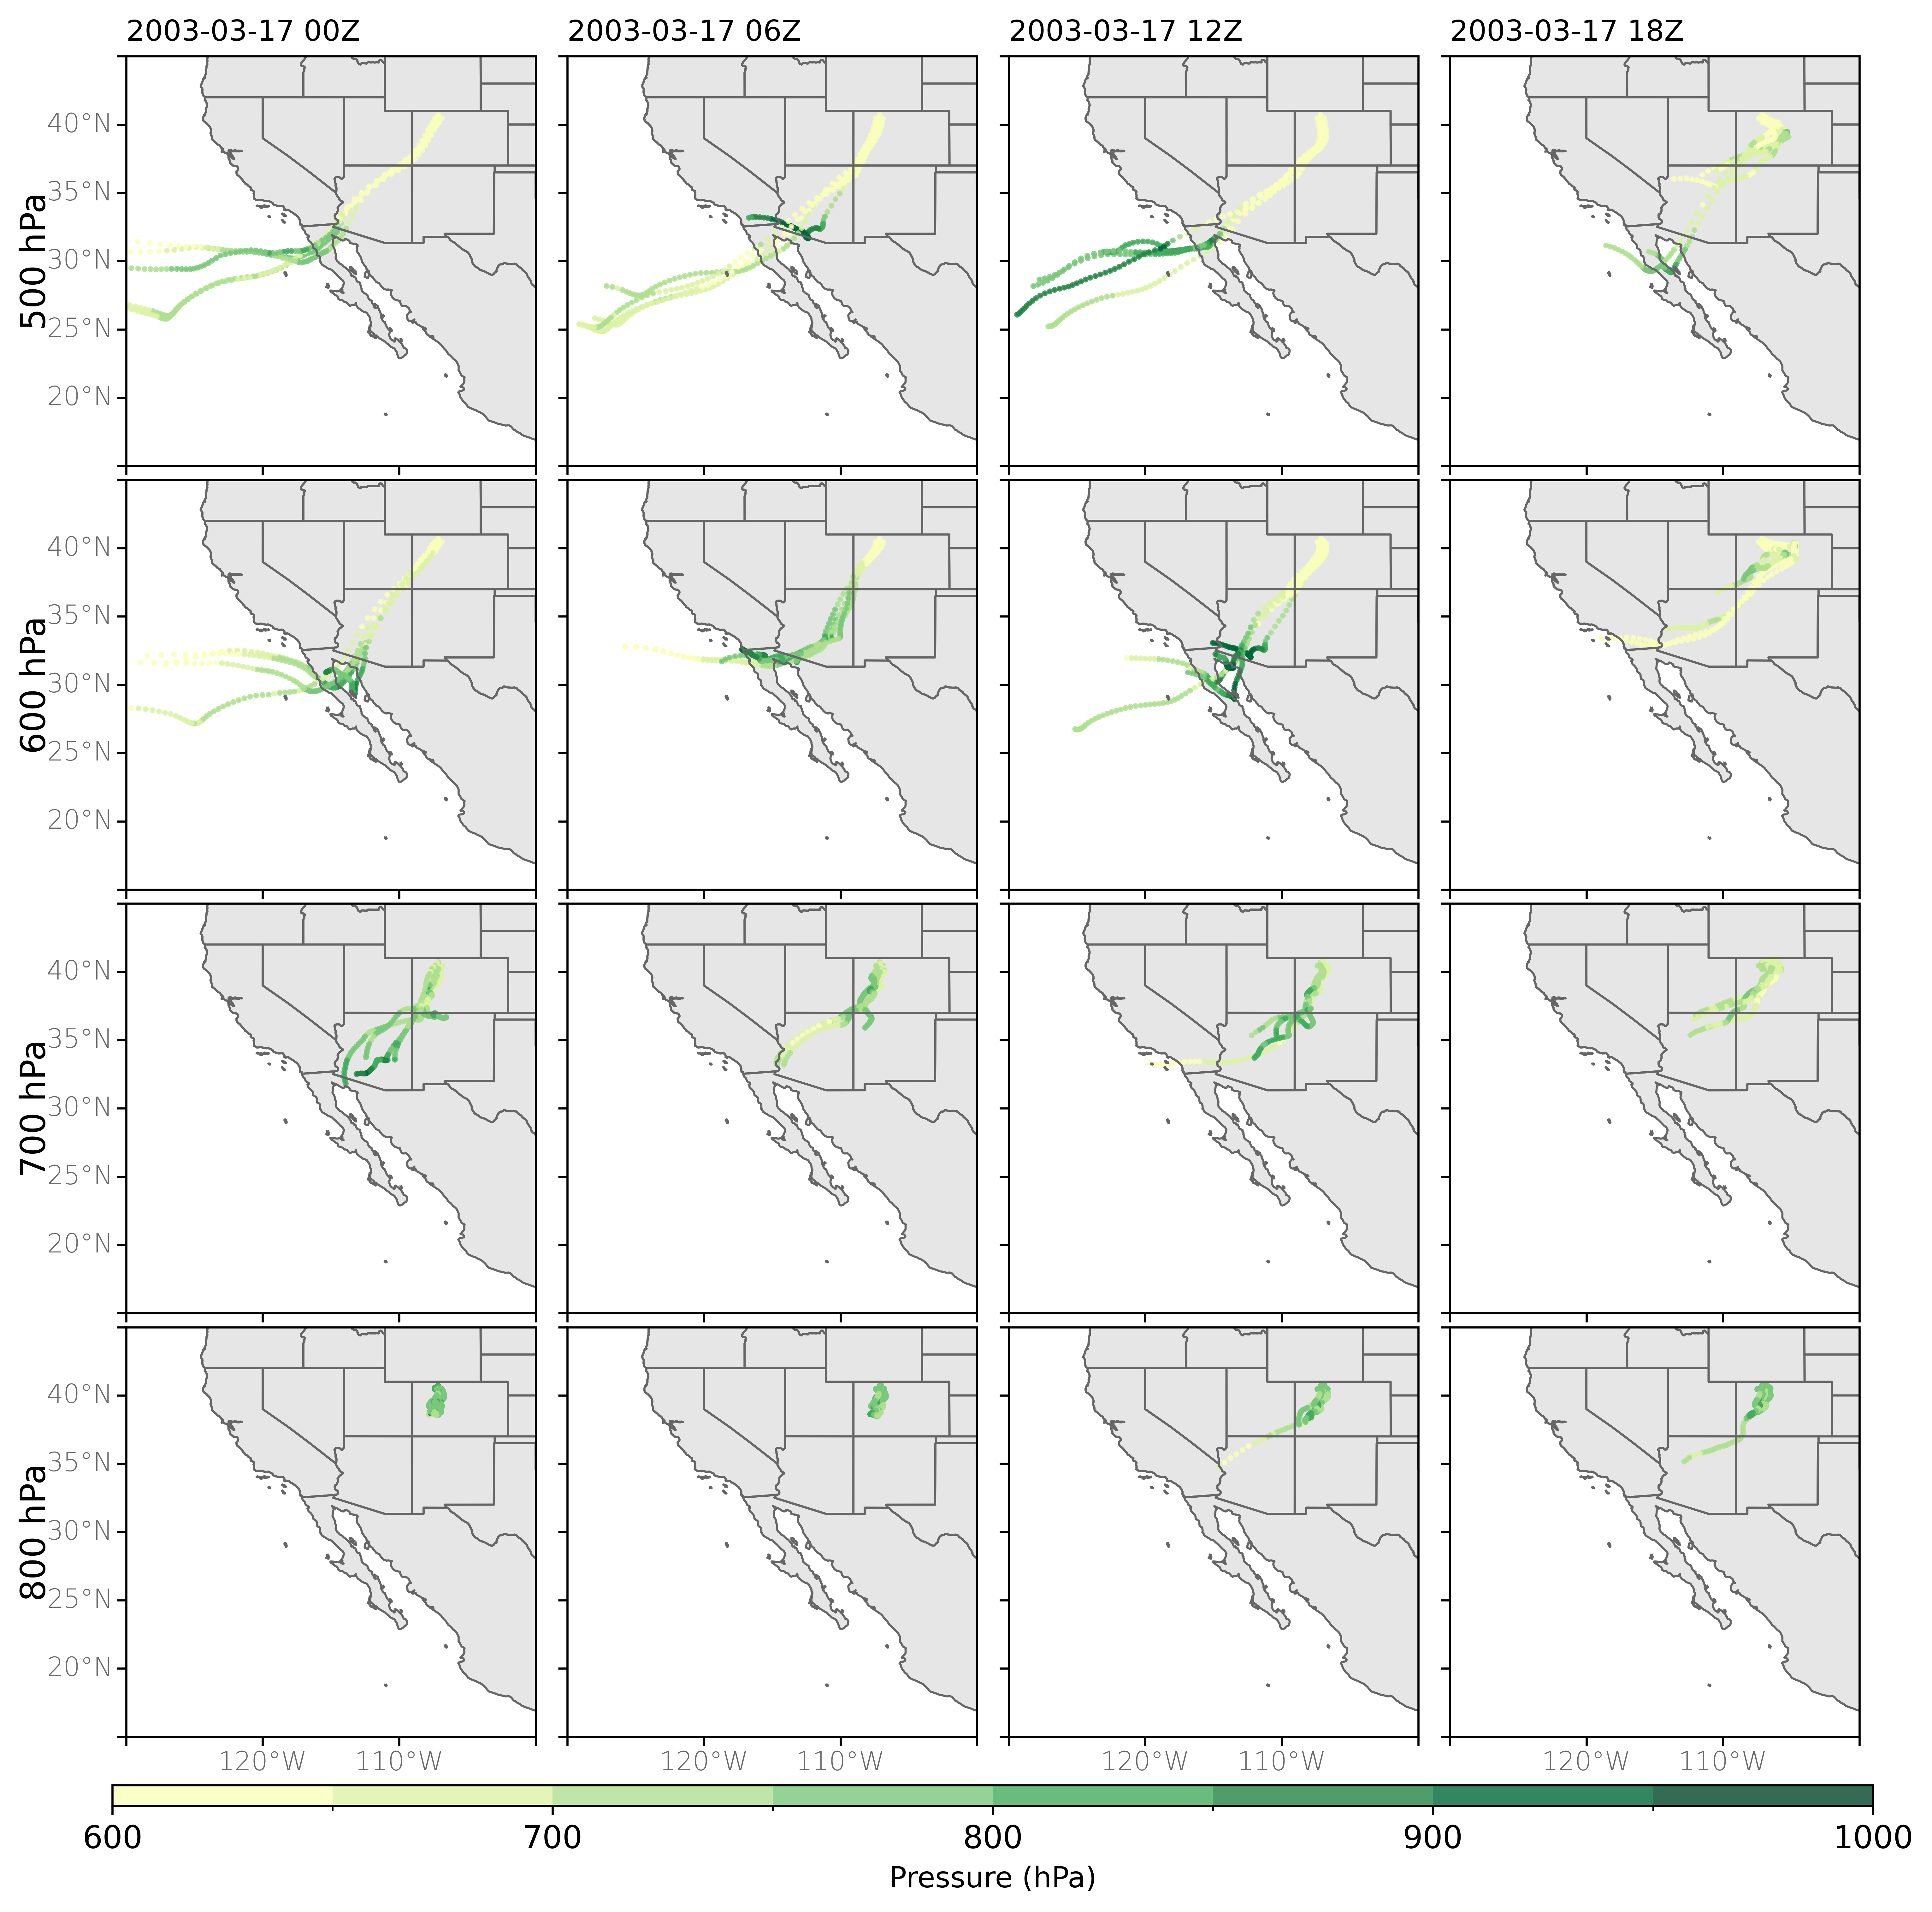

In [12]:
ext = [-130., -100., 15., 45.] 
fmt = 'png'
nrows = 6
ncols = 4

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

fig = plt.figure(figsize=(12.0 ,12.0))
fig.dpi = 600
fname = '../figs/sensitivity_test_trajectory'

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

left_lats = [True, False, False, False]
## each 6 hours gets its own plot
for i, start_date_val in enumerate(tmp.start_date.values):
    for j, lev_val in enumerate(tmp.start_lev.values):
        ax = fig.add_subplot(gs[j, i], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=left_lats[i], right_lats=False)
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        ts = pd.to_datetime(str(start_date_val)) 
        t = ts.strftime('%Y-%m-%d %HZ')
        if j == 0:
            ax.set_title(t, loc='left', fontsize=11)

        if i == 0: # add row labels to the far left plot
            ax.text(-0.18, 0.5, '{0} hPa'.format(str(int(lev_val))), va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
            
        ## start with time step and level
        data = tmp.sel(start_date=start_date_val, start_lev=lev_val)
        
        # need this to fix annotate transform
        transform = datacrs._as_mpl_transform(ax)
        ## Loop through grid
        for k, grid_val in enumerate(data.grid.values):
        
            d = data.sel(grid=grid_val)                
            y_lst = d.latitude.values
            x_lst = d.longitude.values
            z_lst = d.level.values
            cmap, norm, bnds = ccmaps.cmap('pressure')
            cf = ax.scatter(x_lst, y_lst, c=z_lst, cmap=cmap, norm=norm, marker='.', transform=datacrs, alpha=0.8, s=6)

# Add color bar
cbarticks = [200., 300., 400., 500., 600., 700., 800., 900., 1000.]
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label('Pressure (hPa)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()